In [4]:
from __future__ import print_function, division
import os

from torch.autograd import Variable
from image.normalization import normalize_image
from geotnf.transformation import GeometricTnf
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import io
from model.network import WeakMatchNet
from torchvision.transforms import Normalize
import torch
import numpy as np
from default_args import eval_args

use_cuda = torch.cuda.is_available()

GPU = 0
NUM_WORKERS = 4
BATCH_SIZE = 4

torch.cuda.set_device(GPU)

In [5]:
def init_match_model(model_path, arg_groups):

    model = WeakMatchNet(use_cuda=use_cuda, **arg_groups["model"])

    checkpoint = torch.load(
        model_path, map_location=lambda storage, loc: storage
    )

    for name, param in model.FeatureExtraction.state_dict().items():
        try:
            model.FeatureExtraction.state_dict()[name].copy_(
                checkpoint["state_dict"]["FeatureExtraction." + name]
            )
        except KeyError:
            model.FeatureExtraction.state_dict()[name].copy_(
                checkpoint["FeatureExtraction." + name]
            )

    for name, param in model.FeatureRegression.state_dict().items():
        try:
            model.FeatureRegression.state_dict()[name].copy_(
                checkpoint["state_dict"]["FeatureRegression." + name]
            )
        except KeyError:
            model.FeatureRegression.state_dict()[name].copy_(
                checkpoint["FeatureRegression." + name]
            )

    for name, param in model.FeatureRegression2.state_dict().items():
        try:
            model.FeatureRegression2.state_dict()[name].copy_(
                checkpoint["state_dict"]["FeatureRegression2." + name]
            )
        except KeyError:
            model.FeatureRegression2.state_dict()[name].copy_(
                checkpoint["FeatureRegression2." + name]
            )

    return model


def affTpsTnf(source_image, theta_aff, theta_aff_tps, use_cuda=use_cuda):
    tpstnf = GeometricTnf(geometric_model="tps", use_cuda=use_cuda)
    sampling_grid = tpstnf(
        image_batch=source_image,
        theta_batch=theta_aff_tps,
        return_sampling_grid=True,
    )[1]
    X = sampling_grid[:, :, :, 0].unsqueeze(3)
    Y = sampling_grid[:, :, :, 1].unsqueeze(3)
    Xp = (
        X * theta_aff[:, 0].unsqueeze(1).unsqueeze(2)
        + Y * theta_aff[:, 1].unsqueeze(1).unsqueeze(2)
        + theta_aff[:, 2].unsqueeze(1).unsqueeze(2)
    )
    Yp = (
        X * theta_aff[:, 3].unsqueeze(1).unsqueeze(2)
        + Y * theta_aff[:, 4].unsqueeze(1).unsqueeze(2)
        + theta_aff[:, 5].unsqueeze(1).unsqueeze(2)
    )
    sg = torch.cat((Xp, Yp), 3)
    warped_image_batch = F.grid_sample(source_image, sg)

    return warped_image_batch


resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda=False)
normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2, 0, 1)), 0)
    image = torch.Tensor(image.astype(np.float32) / 255.0)
    image_var = Variable(image, requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)

    # Normalize image
    image_var = normalize_image(image_var)

    return image_var

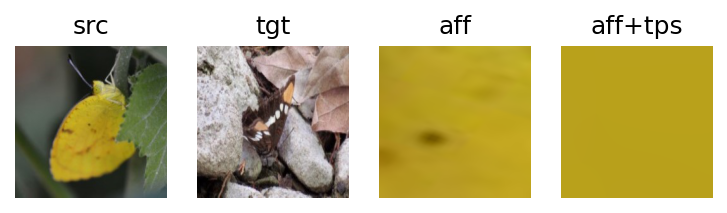

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


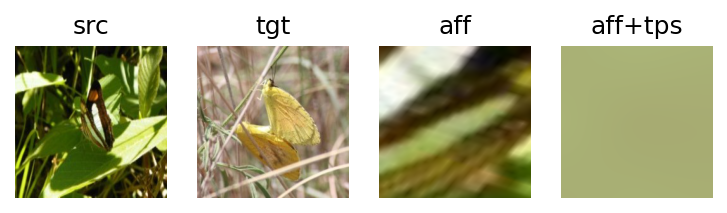

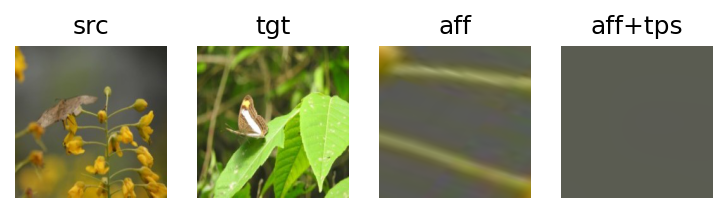

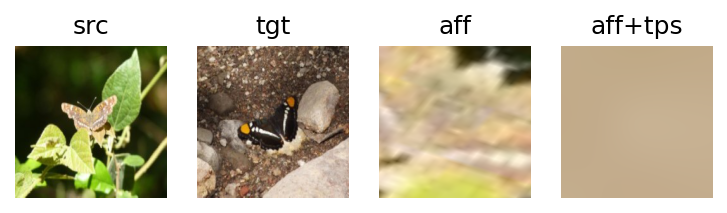

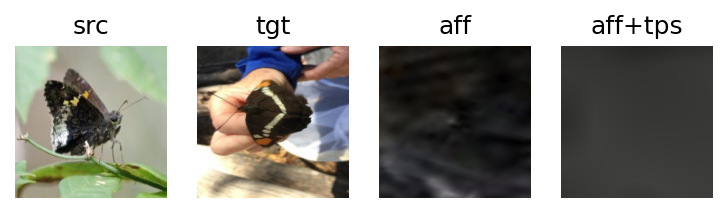

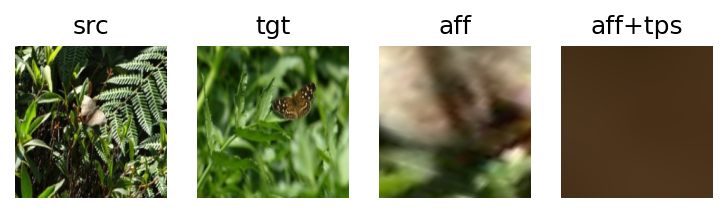

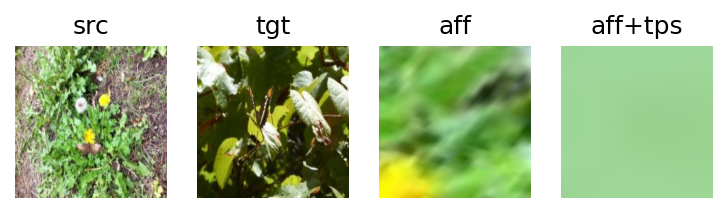

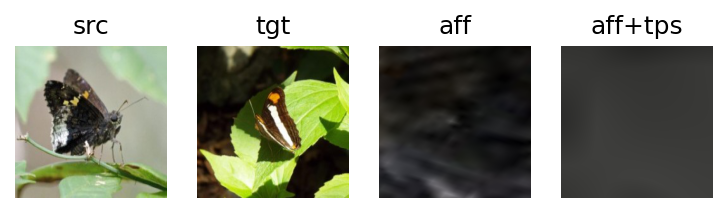

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


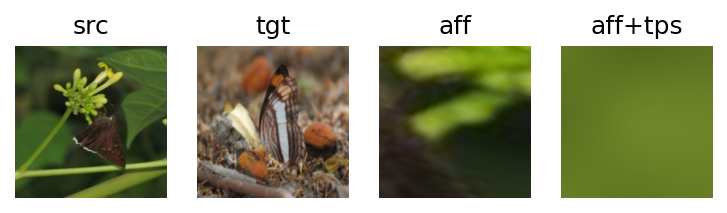

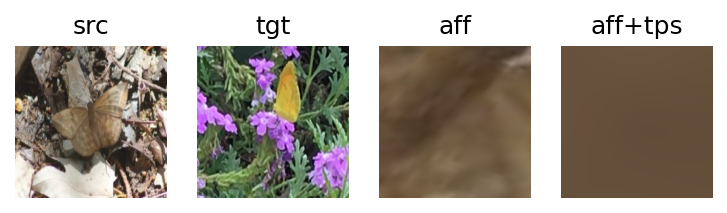

In [6]:
args, arg_groups = eval_args()
model_path = "trained_models/model.pth.tar"
model = init_match_model(model_path, arg_groups)

model.eval()

affTnf = GeometricTnf(geometric_model="affine", use_cuda=use_cuda)

dataset_dir = "/mv_users/danny/datasets/butterfly_240"
join = os.path.join

w, h = (240, 240)
resizeTgt = GeometricTnf(out_h=h, out_w=w, use_cuda=use_cuda)

n = 1522
n_runs = 10
for i in range(n_runs):
    rand = np.random.randint
    idx_1, idx_2 = rand(1, n), rand(1, n)

    source_image_path = join(dataset_dir, f'{idx_1}.jpg')
    target_image_path = join(dataset_dir, f'{idx_2}.jpg')

    source_image = io.imread(source_image_path)
    target_image = io.imread(target_image_path)

    source_image_var = preprocess_image(source_image)
    target_image_var = preprocess_image(target_image)

    if use_cuda:
        source_image_var = source_image_var.cuda()
        target_image_var = target_image_var.cuda()

    batch = {
        "source_image": source_image_var,
        "target_image": target_image_var
    }

    theta_aff, theta_aff_tps = model(batch)

    warped_image_aff = affTnf(batch["source_image"], theta_aff.view(-1, 2, 3))
    warped_image_aff_tps = affTpsTnf(
        batch["source_image"], theta_aff, theta_aff_tps
    )

    # Un-normalize images and convert to numpy
    warped_image_aff_np = (
        normalize_image(resizeTgt(warped_image_aff), forward=False)
        .data.squeeze(0)
        .transpose(0, 1)
        .transpose(1, 2)
        .cpu()
        .numpy()
    )
    warped_image_aff_tps_np = (
        normalize_image(resizeTgt(warped_image_aff_tps), forward=False)
        .data.squeeze(0)
        .transpose(0, 1)
        .transpose(1, 2)
        .cpu()
        .numpy()
    )

    N_subplots = 4
    fig, axs = plt.subplots(1, N_subplots)
    axs[0].imshow(source_image)
    axs[0].set_title("src")
    axs[1].imshow(target_image)
    axs[1].set_title("tgt")
    axs[2].imshow(warped_image_aff_np)
    axs[2].set_title("aff")
    axs[3].imshow(warped_image_aff_tps_np)
    axs[3].set_title("aff+tps")

    for i in range(N_subplots):
        axs[i].axis("off")

    fig.set_dpi(150)
    plt.show()